In [1]:
# Define constants
import time
start_time = time.time()
import math

q = 1.602e-19
eps = 11.68*8.85e-12
boltzmann = 1.38e-23
ni_cm = 1e10
ni = ni_cm*1e6
T = 298
Vt = boltzmann*T/q

Ld = math.sqrt(eps*Vt/q/ni)

In [2]:
# Define grid points, symbolic v(x, y), map (x, y) to grid point index and vice versa

import symengine as se
from symengine import symbols, RealDouble
from symengine.lib.symengine_wrapper import DenseMatrix, Symbol
import numpy as np
from matplotlib import ticker, cm
from matplotlib import pylab as plt
# %matplotlib notebook

box_length = 10e-6*3/Ld
dimension = 16 # number of grid points per axis
elements = dimension*dimension
h_val = box_length/dimension  # normalized h
Nd_val = -1e15/ni_cm
Na_val = 1e17/ni_cm
#bc_val = 0.0
bc_val = 1/Vt
max_bc = 1/Vt
#v_sym = np.full((dimension, dimension), None, dtype=sympy.symbol.Symbol)
v_sym = DenseMatrix(dimension, dimension, [0]*elements)
index = 0
for x in range(dimension):
    for y in range(dimension):
        v_sym[x, y] = Symbol('psi_'+str(index))
        index += 1

def get_xy(index):
    x = math.floor(index/dimension)
    y = index - x*dimension
    return (x, y)
def to_index(x, y):
    return y + x*dimension

def to_val(sym):
    return sym.subs(h, h_val).subs(Na, Na_val).subs(Nd, Nd_val).subs(bc, bc_val)

def convert_plot(arr):
    return np.flipud(arr.transpose())

In [3]:
# doping for x, y
def get_doping(x, y):
    cutoff = math.floor(dimension/2.0)
    if (x+y <= cutoff):
        return Nd
    else:
        return Na  

In [4]:
# get boundary condition given x, y and direction
def get_bc(x, y, pos):
    # left is 0, top is 1, right is 2, bottom is 3
    grid_scale = dimension/3
    if pos == 0 and x == 0:
        if y < grid_scale:
            return bc
        else:
            return 0
    elif pos == 1 and y == 0:
        if x < grid_scale:
            return bc
        else:
            return 0
    else:
        return 0

def get_neighbor(x, y, pos, matrix=v_sym):
    # left is 0, top is 1, right is 2, bottom is 4
    offsets = [(-1, 0), (0, -1), (1, 0), (0, 1)]
    x += offsets[pos][0]
    y += offsets[pos][1]
    if x < 0 or x >= dimension or y < 0 or y >= dimension:
        return 0
    else:
        return matrix[x, y]

def get_top(x, y):
    return get_bc(x, y, 1) + get_neighbor
    

In [5]:
# full symbolic formulation
h = Symbol('h')
Nd = Symbol('Nd')
Na = Symbol('Na')
bc = Symbol('bc')
#v_func_sym = np.full((dimension, dimension), None, dtype=sympy.symbol.Symbol)
v_func_sym = DenseMatrix(dimension, dimension, [0]*elements)
for x in range(dimension):
    for y in range(dimension):
        func = -4*v_sym[x, y]
        for pos in range(4):
            func += get_neighbor(x, y, pos)
            func += get_bc(x, y, pos)
        func += h**2*(se.exp(-v_sym[x, y]) - se.exp(v_sym[x, y]) + get_doping(x, y))
        v_func_sym[x, y] = func
#v_func_sym = np.array(list(v_func_sym.flat))
v_func_sym = v_func_sym.reshape(elements, 1)

In [6]:
# compute the jacobian
v_sym_flat = v_sym.reshape(elements, 1)
jacobian_sym = v_func_sym.jacobian(v_sym_flat)


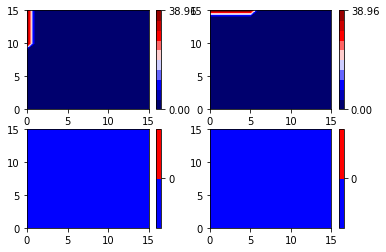

In [7]:
# verify boundary conditions. Each plot is for left, top, right and bottom respectively 

bcs = np.full((4), None, dtype=DenseMatrix)
for i in range(4):
    bcs[i] = DenseMatrix(dimension, dimension, [0]*elements)
    for x in range(dimension):
        for y in range(dimension):
            bcs[i][x, y] = get_bc(x, y, i)


bcs_sub = np.full((4), None, dtype=np.ndarray)
for i in range(4):
    bcs_sub[i] = np.array(bcs[i].subs(bc, bc_val)).astype(np.double).reshape(dimension, dimension)
    
for i in range(4):
    plt.subplot(2, 2, i+1)
    cont = plt.contourf(convert_plot(bcs_sub[i]),
                       locator=ticker.LinearLocator(), 
                       cmap=cm.seismic)
    plt.colorbar(cont, ticks=np.unique(bcs_sub[i]))
plt.show(cont)

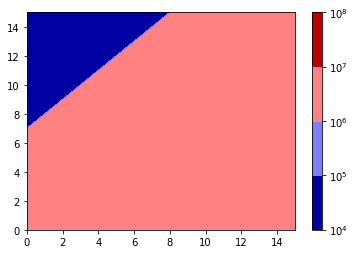

In [8]:
# visually verify doping
doping = DenseMatrix(dimension, dimension, [0]*elements)
for x in range(dimension):
    for y in range(dimension):
        doping[x, y] = get_doping(x, y)
doping = np.array(doping.subs(Na, Na_val).subs(Nd, Nd_val)).reshape(dimension, dimension)
cont = plt.contourf(convert_plot(np.abs(doping)),
                    locator=ticker.LogLocator(),
                    cmap=cm.seismic)
plt.colorbar()
plt.show(cont)

In [9]:
# homogeneous formulation
v_func_homog = DenseMatrix(dimension, dimension, [0]*elements)
for x in range(dimension):
    for y in range(dimension):
        v_func_homog[x, y] = -4*v_sym[x, y]
        for pos in range(4):
            v_func_homog[x, y] = v_func_homog[x, y] + get_neighbor(x, y, pos)

v_coeffs = v_func_homog.reshape(elements, 1).jacobian(v_sym_flat)
v_coeffs = np.array(v_coeffs, dtype=np.double).reshape(elements, elements)
v_coeffs.astype(int)[:8, :8]

array([[-4,  1,  0,  0,  0,  0,  0,  0],
       [ 1, -4,  1,  0,  0,  0,  0,  0],
       [ 0,  1, -4,  1,  0,  0,  0,  0],
       [ 0,  0,  1, -4,  1,  0,  0,  0],
       [ 0,  0,  0,  1, -4,  1,  0,  0],
       [ 0,  0,  0,  0,  1, -4,  1,  0],
       [ 0,  0,  0,  0,  0,  1, -4,  1],
       [ 0,  0,  0,  0,  0,  0,  1, -4]])

In [10]:
#homogeneous solution#linear solution (ignore the nonlinear n_i.exp(-psi/Vt) components)
rhs = DenseMatrix(elements, 1, [0]*elements)
for i in range(elements):
    (x, y) = get_xy(i)
    rhs[i] = h*h*-get_doping(x, y)
    for j in range(4):
        rhs[i] = rhs[i] - get_bc(x, y, j)

rhs = np.array(to_val(rhs).tolist(), dtype=np.double)
homog_soln = np.linalg.solve(v_coeffs, rhs)
homog_soln*= Vt
#print homog_soln.reshape((dimension, dimension))
    

In [11]:
# Test solution.  del2/rhs should be 1
sol = homog_soln.reshape((dimension, dimension))

def verify_soln(x, y):
    neighbors = 0
    for i in range(4):
        neighbors += Vt*get_bc(x, y, i) + get_neighbor(x, y, i, sol)
    del2 = to_val((neighbors - 4*sol[x][y])/(h*Ld)**2)
    rhs = to_val((-q*get_doping(x, y)*ni/eps))
    return del2, rhs, del2/rhs
    
print(verify_soln(2, 2)[2])
print(verify_soln(0, 0)[2])

1.00000000000037
1.00000000000001


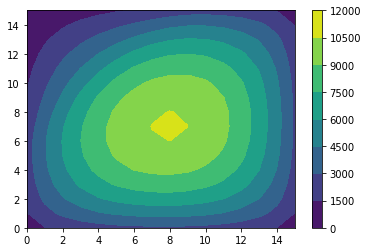

In [12]:
cont = plt.contourf(convert_plot(sol))
plt.colorbar(cont)
plt.show(cont)

In [13]:
# evaluate f(v)
import re
pattern = 'psi_([0-9]+)'
prog = re.compile(pattern)

vfunc_indices = np.empty((elements), dtype=np.ndarray)
for i in range(elements):
    vfunc_indices[i] = list(map(int, np.unique(prog.findall(str(v_func_sym[i])))))

def evaluate_f(v_func, soln):
    temp_eval = np.copy(v_func)
    for i in range(elements):
        for j in vfunc_indices[i]:
            temp_eval[i] = temp_eval[i].subs(v_sym_flat[j], soln[j])
    return list(map(RealDouble.to_double, temp_eval))




In [14]:
# evaluate jacobian
# jacobian is independent of bc
jacobian = to_val(jacobian_sym)
jacobian_eval = np.copy(jacobian).reshape(elements, elements)
np.fill_diagonal(jacobian_eval, 0)
jacobian_eval = jacobian_eval.astype(np.double)


# to make indexing faster
jacobian_diag = np.diag(np.array(jacobian).reshape(elements, elements))

range_index = range(elements)
def evaluate_jacobian(soln):
    for i in range_index:
        jacobian_eval[i][i] = jacobian_diag[i].subs(v_sym_flat[i], soln[i])
    return jacobian_eval

In [15]:
#initial_soln = np.zeros(elements)
#%timeit evaluate_f(initial_soln)
#%timeit evaluate_jacobian(initial_soln)

In [16]:
# nonlinear solution, solve by gradually stepping boundary condition
source_steps = 18

no_plots = 6
plot_step = int(source_steps/no_plots)
plot_index = 0

v_data = np.empty((no_plots, dimension, dimension), dtype=np.double)
f_data = np.empty((no_plots), dtype=np.ndarray)

max_iterations = 30
tol = 1e-8
initial_sol = np.zeros(elements)

curr_sol = initial_sol
source_step = 0

bc_vals = np.linspace(0, -1/Vt, source_steps)

for source_step in range(source_steps):
    
    bc_val = bc_vals[source_step]
    v_func = np.squeeze(to_val(v_func_sym).tolist())
    f_sol = evaluate_f(v_func, curr_sol)
    f_sum = np.absolute(f_sol).sum()
    min_t = -20
    print('bc = {} :'.format(bc_val*Vt), end=""),
    for i in range(max_iterations):
        print('{}..'.format(i), end=""), 
        f_sol = evaluate_f(v_func, curr_sol)
        jacobian_sol = evaluate_jacobian(curr_sol)
        del_v = -np.linalg.solve(jacobian_sol, f_sol)
        t = 2
        f_sum = np.absolute(f_sol).sum()
        # line search
        while t > min_t:
            scale = 2**t
            temp_sol = curr_sol + scale*del_v
            temp_f_sol = evaluate_f(v_func, temp_sol)
            temp_sum = np.absolute(temp_f_sol).sum()
            if temp_sum < f_sum:
                curr_sol = temp_sol
                f_sol = temp_f_sol
                break
            #print 't = ', t
            t -= 1
        if t <= min_t:
            print("No t reduces F(V)")
            break
        if temp_sum < tol:
            break
    if source_step % plot_step == 0:
        v_data[plot_index] = Vt*curr_sol.reshape((dimension, dimension))
        f_data[plot_index] = np.array(f_sol).reshape((dimension, dimension))
        plot_index += 1
    print('\n')



    



bc = 0.0 :0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..

bc = -0.05882352941176472 :0..1..2..3..

bc = -0.11764705882352944 :0..1..2..3..

bc = -0.17647058823529416 :0..1..2..3..

bc = -0.23529411764705888 :0..1..2..3..

bc = -0.2941176470588236 :0..1..2..3..

bc = -0.3529411764705883 :0..1..2..3..

bc = -0.41176470588235303 :0..1..2..3..

bc = -0.47058823529411775 :0..1..2..3..

bc = -0.5294117647058825 :0..1..2..3..

bc = -0.5882352941176472 :0..1..2..3..

bc = -0.6470588235294119 :0..1..2..3..

bc = -0.7058823529411766 :0..1..2..3..

bc = -0.7647058823529413 :0..1..2..3..

bc = -0.8235294117647061 :0..1..2..3..

bc = -0.8823529411764707 :0..1..2..3..

bc = -0.9411764705882355 :0..1..2..3..

bc = -1.0 :0..1..2..3..



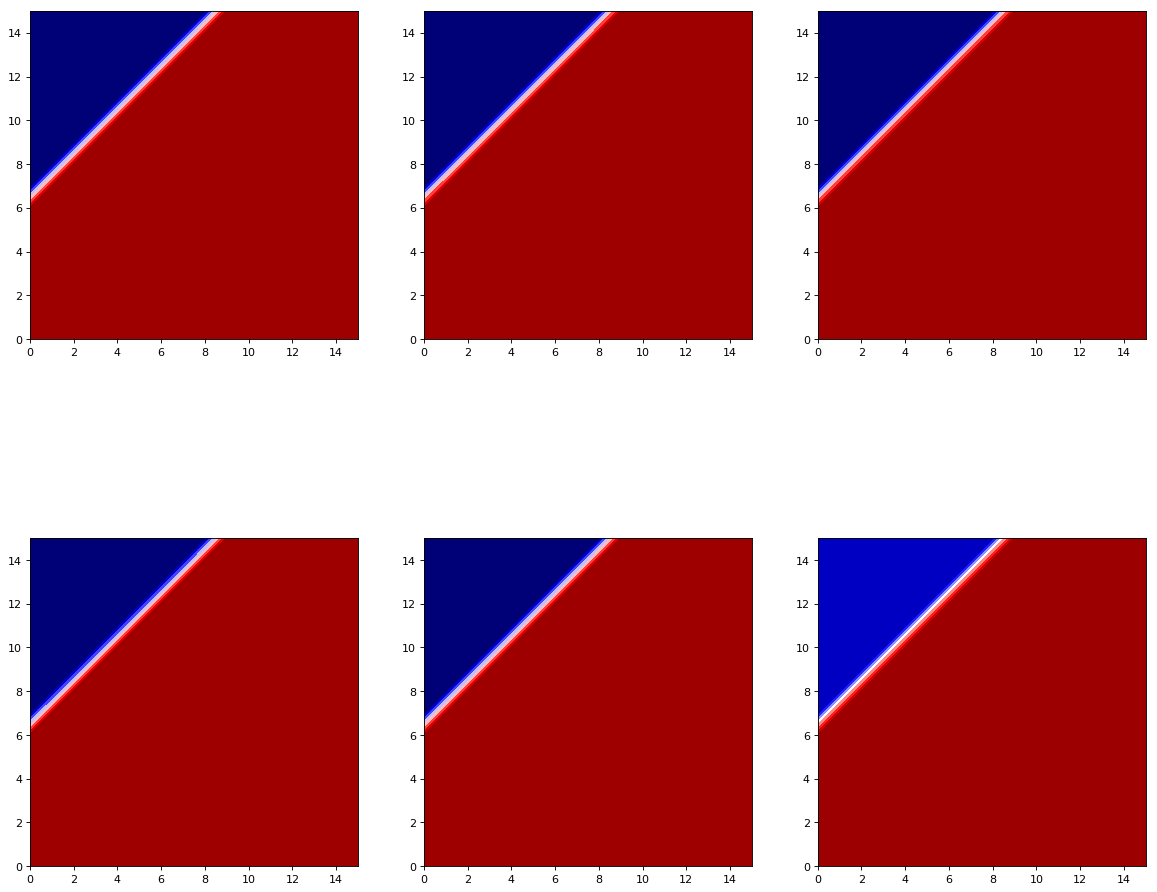

In [17]:
# Plot solution for selected boundary conditions

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 16), dpi= 80,)
axes = axes.flat

for i in range(no_plots):
    ax = axes[i]
    cont = ax.contourf(convert_plot(v_data[i]), 
                      locator=ticker.AutoLocator(), 
                       cmap=cm.seismic)
    #ticks = np.linspace(v_data[i].min(), v_data[i].max(), 5)
    #plt.colorbar(cont, ax=ax, ticks=ticks, format='%.2f')
    #ax.axis('off')
    ax.set_aspect('equal')
    plot_index += 1

#plt.subplots_adjust(wspace=0.3)
plt.show()
#plt.rcParams['figure.figsize'] = default_plot_size

Notes

Slide 24, 34 3rd line of Differentiation matrix is incorrect for 3x3 grid. Correct matrix presented below

Slide 30, no factor of 2 for Ld

Slide 28, 34 clarification for which region is n-type or p-type is needed. Bullet points 3 and 4 on slide 28 contradict reverse bias condition specified in the hacker practice on page 34

Slide 31, 32, 34 boundary conditions should not be multiplied by h^2

$$ \frac{\partial^2 \psi}{\partial x^2} + \frac{\partial^2 \psi}{\partial y^2} = -q \frac{n_i\exp(-\frac{\psi}{V_T}) - n_i\exp(\frac{\psi}{V_T}) + N(x, y) }{\epsilon_{si}} $$

$$ \frac{\partial^2 \psi }{\partial x^2 V_T} + \frac{\partial^2 \psi}{\partial y^2 V_T} = \frac{-q n_i}{\epsilon_{si} V_T} \left( \exp(-\psi') - \exp(\psi') + \frac{N(x, y)}{n_i} \right) $$

Let $$\psi' = \frac{\psi}{V_T}$$
$$L_D^2 = \frac{\epsilon_{si} V_T}{-q n_i} $$
$$ N' = \frac{N(x, y)}{n_i} $$ 
$$ x' = \frac{x}{L_D} $$ 
$$ y' = \frac{y}{L_D} $$

$$ \frac{\partial^2 \psi'}{\partial x'^2 L_D^2} + \frac{\partial^2 \psi'}{\partial y'^2L_D^2} = \frac{1}{L_D^2} \left( \exp(-\psi') - \exp(\psi') + N'  \right) $$

$$ \frac{\partial^2 \psi'}{\partial x'^2 } + \frac{\partial^2 \psi'}{\partial y'^2} = \exp(-\psi') - \exp(\psi') + N'  $$

Construct differentiation matrix using symbolic maths for 3x3 grid

In [19]:
dimension = 3
elements = dimension * dimension
# construct v_sym
v_sym = DenseMatrix(dimension, dimension, [0]*elements)
index = 0
for x in range(dimension):
    for y in range(dimension):
        v_sym[x, y] = Symbol('psi_'+str(index))
        index += 1
v_sym_flat = v_sym.reshape(elements, 1)
# construct v_func
v_func_homog = DenseMatrix(dimension, dimension, [0]*elements)
for x in range(dimension):
    for y in range(dimension):
        v_func_homog[x, y] = -4*v_sym[x, y]
        for pos in range(4):
            v_func_homog[x, y] = v_func_homog[x, y] + get_neighbor(x, y, pos, matrix=v_sym)


v_coeffs = v_func_homog.reshape(elements, 1).jacobian(v_sym_flat)
v_coeffs = np.array(v_coeffs, dtype=np.int).reshape(elements, elements)
#v_func_homog
print(v_func_homog)
print(v_coeffs)

[-4*psi_0 + psi_1 + psi_3, psi_0 - 4*psi_1 + psi_2 + psi_4, psi_1 - 4*psi_2 + psi_5]
[psi_0 - 4*psi_3 + psi_4 + psi_6, psi_1 + psi_3 - 4*psi_4 + psi_5 + psi_7, psi_2 + psi_4 - 4*psi_5 + psi_8]
[psi_3 - 4*psi_6 + psi_7, psi_4 + psi_6 - 4*psi_7 + psi_8, psi_5 + psi_7 - 4*psi_8]

[[-4  1  0  1  0  0  0  0  0]
 [ 1 -4  1  0  1  0  0  0  0]
 [ 0  1 -4  0  0  1  0  0  0]
 [ 1  0  0 -4  1  0  1  0  0]
 [ 0  1  0  1 -4  1  0  1  0]
 [ 0  0  1  0  1 -4  0  0  1]
 [ 0  0  0  1  0  0 -4  1  0]
 [ 0  0  0  0  1  0  1 -4  1]
 [ 0  0  0  0  0  1  0  1 -4]]
